# Investigate a potential blob bump on mainnet
See .env.example to set the environment variables.

In [1]:
!pip install jupysql clickhouse_sqlalchemy matplotlib python-dotenv pandas seaborn imageio > /dev/null 2>&1

In [2]:
import dotenv
import os
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import imageio

dotenv.load_dotenv()

# Load and display config
start_date = os.getenv('START_DATE_TIME')
if not start_date:
    raise ValueError("START_DATE_TIME environment variable is required")

end_date = os.getenv('END_DATE_TIME')
if not end_date:
    end_date = datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")

network = os.getenv('NETWORK')

print(f"start_date: {start_date}")
print(f"end_date: {end_date}")

# Convert start and end dates to datetime objects
try:
    start_dt = datetime.fromisoformat(start_date.replace("Z", "+00:00"))
except ValueError as e:
    raise ValueError(f"Invalid start date format. Date must be in ISO format. Error: {str(e)}")

try:
    if isinstance(end_date, datetime):
        end_dt = end_date
    else:
        end_dt = datetime.fromisoformat(str(end_date).replace("Z", "+00:00"))
except ValueError as e:
    raise ValueError(f"Invalid end date format. Date must be in ISO format. Error: {str(e)}")

# Calculate the difference in hours
hours = (end_dt - start_dt).total_seconds() / 3600

print(f"hours: {hours}")


start_date: 2024-10-04T22:00:00Z
end_date: 2024-11-25T02:00:00Z
hours: 1228.0


In [3]:
# Connect to ClickHouse
import os
username = os.getenv('XATU_CLICKHOUSE_USERNAME')
password = os.getenv('XATU_CLICKHOUSE_PASSWORD')
host = os.getenv('XATU_CLICKHOUSE_HOST')


db_url = f"clickhouse+http://{username}:{password}@{host}:443/default?protocol=https"

from sqlalchemy import create_engine, text

engine = create_engine(db_url)

connection = engine.connect()

In [4]:
# Query for MEV relay delivered slots
block_query = text("""
    SELECT DISTINCT
        slot
    FROM mev_relay_proposer_payload_delivered FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_network_name = 'mainnet'
    ORDER BY slot ASC
""")

result = connection.execute(block_query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')})
mev_slots = pd.DataFrame(result.fetchall(), columns=['slot'])

print(mev_slots)

            slot
0       10104599
1       10104600
2       10104601
3       10104602
4       10104603
...          ...
337584  10472993
337585  10472995
337586  10472996
337587  10472997
337588  10472998

[337589 rows x 1 columns]


In [5]:
# Query for all slots in time window
all_slots_query = text("""
    SELECT DISTINCT
        slot,
        slot_start_date_time as time
    FROM beacon_api_eth_v1_events_block FINAL 
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_network_name = 'mainnet'
    ORDER BY slot ASC
""")

result = connection.execute(all_slots_query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')})
all_slots = pd.DataFrame(result.fetchall(), columns=['slot', 'time'])


In [6]:
# Query to get block sizes for all slots
print("Getting block sizes...")
block_sizes_query = text("""
    SELECT 
        slot,
        block_total_bytes_compressed,
        slot_start_date_time as time,
        proposer_index,
        block_root
    FROM canonical_beacon_block FINAL
    WHERE 
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_network_name = 'mainnet'
""")
block_sizes = pd.DataFrame(
    connection.execute(block_sizes_query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')}).fetchall(),
    columns=['slot', 'block_total_bytes_compressed', 'time', 'proposer_index', 'block_root']
)

print("Getting proposer entities...")
# Get proposer entities
proposer_query = text("""
    SELECT 
        `index` as proposer_index,
        entity
    FROM ethseer_validator_entity
    WHERE 
        meta_network_name = 'mainnet'
""")
proposer_entities = pd.DataFrame(
    connection.execute(proposer_query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')}).fetchall(),
    columns=['proposer_index', 'entity']
)

print("Getting blob sidecar data...")
# Get blob sidecar data for our slots
blob_sidecars_query = text("""
    SELECT 
        slot,
        COUNT(*) as num_blobs,
        SUM(blob_size) as total_blob_size
    FROM canonical_beacon_blob_sidecar FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_network_name = 'mainnet'
    GROUP BY slot, toDate(slot_start_date_time)
""")
blob_sidecars = pd.DataFrame(
    connection.execute(blob_sidecars_query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')}).fetchall(),
    columns=['slot', 'num_blobs', 'total_blob_size']
)

print("Getting first seen in p2p data...")
first_seen_in_p2p_query = text("""
    SELECT
        slot,
        block as block_root,
        MIN(propagation_slot_start_diff) as first_seen_in_p2p
    FROM libp2p_gossipsub_beacon_block FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_network_name = 'mainnet'
    GROUP BY slot, block
""")
first_seen_in_p2p = pd.DataFrame(
    connection.execute(first_seen_in_p2p_query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')}).fetchall(),
    columns=['slot', 'block_root', 'first_seen_in_p2p']
)

print("Getting first seen attestation for block in p2p data...")
first_seen_attestation_in_p2p_query = text("""
    SELECT
        slot,
        beacon_block_root as block_root,
        MIN(propagation_slot_start_diff) as first_seen_attestation_in_p2p
    FROM libp2p_gossipsub_beacon_attestation FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_network_name = 'mainnet'
    GROUP BY slot, beacon_block_root
""")
first_seen_attestation_in_p2p = pd.DataFrame(
    connection.execute(first_seen_attestation_in_p2p_query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')}).fetchall(),
    columns=['slot', 'block_root', 'first_seen_attestation_in_p2p']
)

print("Getting arrival times...")
aggregated_arrival_times_query = text("""
    WITH arrival_times AS (
        SELECT
            slot,
            slot_start_date_time,
            meta_client_name,
            propagation_slot_start_diff
        FROM beacon_api_eth_v1_events_head FINAL
        WHERE
            slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
            AND meta_client_name != ''
            AND meta_client_name IS NOT NULL
            AND meta_network_name = 'mainnet'
            AND propagation_slot_start_diff < 6000
    )
    SELECT
        slot,
        CASE
            WHEN meta_client_name NOT LIKE 'ethpandaops%' THEN 'home users'
            ELSE 'ethpandaops'
        END as observed_by_group,
        min(propagation_slot_start_diff) as min_arrival_time,
        quantile(0.50)(propagation_slot_start_diff) as p50_arrival_time,
        quantile(0.90)(propagation_slot_start_diff) as p90_arrival_time,
        quantile(0.99)(propagation_slot_start_diff) as p99_arrival_time
    FROM arrival_times
    GROUP BY 
        slot,
        CASE
            WHEN meta_client_name NOT LIKE 'ethpandaops%' THEN 'home users'
            ELSE 'ethpandaops'
        END
    ORDER BY slot
""")

aggregated_arrival_times = pd.DataFrame(
    connection.execute(aggregated_arrival_times_query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')}).fetchall(),
    columns=['slot', 'observed_by_group', 'min_arrival_time', 'p50_arrival_time', 'p90_arrival_time', 'p99_arrival_time']
)

# Convert blob_sidecars to a dictionary
blob_sidecars_map = blob_sidecars.set_index('slot').to_dict(orient='index')

# Build combined data using block_sizes as the canonical list of slots
combined_data = block_sizes.copy()
combined_data = combined_data.merge(proposer_entities, on='proposer_index', how='left')
# combined_data = combined_data.merge(first_seen_in_p2p, on=['slot', 'block_root'], how='left')
# combined_data = combined_data.merge(first_seen_attestation_in_p2p, on=['slot', 'block_root'], how='left')
# combined_data = combined_data.merge(arrival_times[['slot', 'min_arrival_time', 'p50_arrival_time', 'p90_arrival_time', 'p99_arrival_time']], on='slot', how='left')
combined_data['num_blobs'] = combined_data['slot'].map(lambda slot: blob_sidecars_map.get(slot, {'num_blobs': 0})['num_blobs'])
combined_data['total_blob_size'] = combined_data['slot'].map(lambda slot: blob_sidecars_map.get(slot, {'total_blob_size': 0})['total_blob_size'])

# Calculate total data per slot
combined_data['total_data_per_slot'] = combined_data['block_total_bytes_compressed'] + combined_data['total_blob_size']
combined_data['total_size_mb'] = (combined_data['block_total_bytes_compressed'] + combined_data['total_blob_size']) / 1_000_000  


combined_data['block_pct'] = combined_data['block_total_bytes_compressed'] / combined_data['total_data_per_slot'] * 100
combined_data['blob_pct'] = combined_data['total_blob_size'] / combined_data['total_data_per_slot'] * 100

# Add 'via_mev' column to combined_data
combined_data['via_mev'] = combined_data['slot'].isin(mev_slots['slot'])
combined_data['date'] = pd.to_datetime(combined_data['time']).dt.date


# Create a dataframe with slots and their sizes
mev_slots_with_sizes = combined_data[combined_data['via_mev'] == True]
non_mev_slots_with_sizes = combined_data[combined_data['via_mev'] == False]


Getting block sizes...
Getting proposer entities...
Getting blob sidecar data...
Getting first seen in p2p data...
Getting first seen attestation for block in p2p data...
Getting arrival times...


In [7]:
# # Calculate which event happened first for each slot
# combined_data['first_event'] = combined_data.apply(lambda row: min(
#     row['first_seen_in_p2p'] or float('inf'),
#     row['first_seen_attestation_in_p2p'] or float('inf'), 
#     row['min_arrival_time'] or float('inf')
# ), axis=1)

# # Create labels for each event type
# combined_data['first_event_type'] = combined_data.apply(lambda row: 
#     'Block in P2P' if row['first_seen_in_p2p'] == row['first_event'] 
#     else 'Attestation for Block in P2P' if row['first_seen_attestation_in_p2p'] == row['first_event']
#     else 'Block Arrival', axis=1)

# # Create 15 slot buckets and get bucket ranges
# combined_data['slot_bucket'], bins = pd.qcut(combined_data['slot'], q=15, labels=False, retbins=True)
# bucket_ranges = [f'{int(bins[i])}-{int(bins[i+1])}' for i in range(len(bins)-1)]

# # Calculate percentages per bucket
# bucket_counts = combined_data.groupby(['slot_bucket', 'first_event_type']).size().unstack(fill_value=0)
# bucket_percentages = bucket_counts.div(bucket_counts.sum(axis=1), axis=0) * 100

# # Create stacked bar chart with improved styling
# plt.figure(figsize=(16, 8))
# ax = bucket_percentages.plot(
#     kind='bar', 
#     stacked=True, 
#     color=['#3498db', '#2ecc71', '#e74c3c'],
#     width=0.8
# )

# plt.title('Distribution of First Block Event Type by Slot Range', pad=20, fontsize=16, fontweight='bold')
# plt.xlabel('Slot Range', fontsize=14)
# plt.ylabel('Percentage', fontsize=14)

# # Customize legend
# plt.legend(
#     title='Event Type',
#     title_fontsize=12,
#     fontsize=10,
#     bbox_to_anchor=(1.05, 1),
#     loc='upper left',
#     borderaxespad=0
# )

# # Customize grid
# plt.grid(axis='y', linestyle='--', alpha=0.3)

# # Set x-axis labels to slot ranges
# plt.xticks(range(len(bucket_ranges)), bucket_ranges, rotation=45, ha='right')

# plt.show()

# # Print statistics
# print("\nAverage Distribution Across Buckets:")
# avg_pct = bucket_percentages.mean()
# for event_type, pct in avg_pct.items():
#     print(f"{event_type}: {pct:.1f}%")


In [8]:
# # Calculate processing delay by comparing p2p arrival vs block arrival
# processing_delay = combined_data[['slot', 'first_seen_in_p2p', 'min_arrival_time']].dropna()
# processing_delay['delay'] = processing_delay['min_arrival_time'] - processing_delay['first_seen_in_p2p']

# # Filter out negative delays
# processing_delay = processing_delay[processing_delay['delay'] >= 0]

# # Create 15 slot buckets and get bucket ranges
# processing_delay['slot_bucket'], bins = pd.qcut(processing_delay['slot'], q=15, labels=False, retbins=True)
# bucket_ranges = [f'{int(bins[i])}-{int(bins[i+1])}' for i in range(len(bins)-1)]

# # Calculate median delay and 95th/5th percentiles per bucket
# bucket_stats = pd.DataFrame({
#     'median': processing_delay.groupby('slot_bucket')['delay'].median(),
#     'p95': processing_delay.groupby('slot_bucket')['delay'].apply(lambda x: x.quantile(0.95)),
#     'p5': processing_delay.groupby('slot_bucket')['delay'].apply(lambda x: x.quantile(0.05))
# })

# # Create figure with proper size
# plt.figure(figsize=(8, 5.5))

# # Plot median and percentiles for each bucket
# plt.bar(range(len(bucket_ranges)), bucket_stats['median'], 
#         alpha=0.7, color='#3498db', label='Median delay')
# plt.plot(range(len(bucket_ranges)), bucket_stats['p95'], 
#          color='#e74c3c', label='95th percentile', linewidth=2)
# plt.plot(range(len(bucket_ranges)), bucket_stats['p5'],
#          color='#2ecc71', label='5th percentile', linewidth=2)

# # Style the plot
# plt.title('Block Processing Delay Distribution by Slot Range', pad=20, fontsize=14, fontweight='bold')
# plt.xlabel('Slot Range', fontsize=12)
# plt.ylabel('Processing Delay (ms)', fontsize=12)
# plt.grid(True, alpha=0.3, linestyle='--')
# plt.legend(fontsize=10)

# # Set x-axis labels to slot ranges
# plt.xticks(range(len(bucket_ranges)), bucket_ranges, rotation=45, ha='right')

# # Adjust layout to prevent label cutoff
# plt.tight_layout()
# plt.show()

# print(f"Overall median processing delay: {processing_delay['delay'].median():.2f}ms")
# print(f"Overall 95th percentile delay: {processing_delay['delay'].quantile(0.95):.2f}ms")
# print(f"Overall 5th percentile delay: {processing_delay['delay'].quantile(0.05):.2f}ms")


In [9]:
# Get head arrival times per client
print("Getting head arrival times...")
head_arrival_query = text("""
    SELECT 
        slot,
        MIN(propagation_slot_start_diff) as head_arrival_time,
        meta_client_name
    FROM beacon_api_eth_v1_events_head FINAL
    WHERE 
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_network_name = 'mainnet'
    GROUP BY slot, meta_client_name
""")
head_arrival_times = pd.DataFrame(
    connection.execute(head_arrival_query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')}).fetchall(),
    columns=['slot', 'head_arrival_time', 'meta_client_name']
)


Getting head arrival times...


In [10]:
# Get block arrival times per client
print("Getting block arrival times...")
block_arrival_query = text("""
    SELECT 
        slot,
        MIN(propagation_slot_start_diff) as block_arrival_time,
        meta_client_name
    FROM beacon_api_eth_v1_events_block FINAL
    WHERE 
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_network_name = 'mainnet'
    GROUP BY slot, meta_client_name
""")
block_arrival_times = pd.DataFrame(
    connection.execute(block_arrival_query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')}).fetchall(),
    columns=['slot', 'block_arrival_time', 'meta_client_name']
)


Getting block arrival times...


In [11]:
# Get blob arrival times per client
print("Getting blob arrival times...")
blob_arrival_query = text("""
    SELECT
        slot,
        MAX(propagation_slot_start_diff) as last_blob_arrival_time,
        meta_client_name
    FROM beacon_api_eth_v1_events_blob_sidecar FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC') 
        AND meta_network_name = 'mainnet'
    GROUP BY slot, meta_client_name
""")
blob_arrival_times = pd.DataFrame(
    connection.execute(blob_arrival_query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')}).fetchall(),
    columns=['slot', 'last_blob_arrival_time', 'meta_client_name']
)


Getting blob arrival times...


In [12]:
# Merge all arrival times into one dataframe
raw_arrival_data = pd.merge(head_arrival_times, block_arrival_times, on=['slot', 'meta_client_name'], how='outer')
raw_arrival_data = pd.merge(raw_arrival_data, blob_arrival_times, on=['slot', 'meta_client_name'], how='outer')

# Get the latest arrival time between head/block/blob for each client/slot
# Handle missing columns by using fillna
raw_arrival_data['arrival_time'] = raw_arrival_data[[
    'head_arrival_time', 
    'block_arrival_time', 
    'last_blob_arrival_time'
]].fillna(-float('inf')).max(axis=1)

print(raw_arrival_data)

             slot  head_arrival_time  \
0        10236340             3005.0   
1        10427608             2641.0   
2        10412216             4266.0   
3        10407717             2245.0   
4        10323359             2809.0   
...           ...                ...   
8739753  10278462                NaN   
8739754  10304762                NaN   
8739755  10281650                NaN   
8739756  10460650                NaN   
8739757  10370934                NaN   

                                          meta_client_name  \
0          pub-asn-city/impulsecanopener30/hashed-776f28d8   
1                pub-asn-city/simplefrog47/hashed-aee32110   
2          pub-asn-city/impulsecanopener30/hashed-776f28d8   
3        ethpandaops/mainnet/sigma-mainnet-nimbus-besu-001   
4        ethpandaops/mainnet/xatu-sentry-syd1-mainnet-p...   
...                                                    ...   
8739753    ethpandaops/mainnet/sigma-mainnet-teku-geth-001   
8739754    ethpandaops/

In [14]:
# Add country and group info
query = text("""
    SELECT 
        meta_client_name,
        meta_client_geo_country as country,
        CASE
            WHEN meta_client_name NOT LIKE 'ethpandaops%' THEN 'home users'
            ELSE 'ethpandaops'
        END as observed_by_group
    FROM beacon_api_eth_v1_events_head FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_client_name != ''
        AND meta_client_name IS NOT NULL
        AND meta_network_name = 'mainnet'
    GROUP BY meta_client_name, meta_client_geo_country
""")

client_info = pd.DataFrame(
    connection.execute(query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')}).fetchall(),
    columns=['meta_client_name', 'country', 'observed_by_group']
)

print("Query done.. merging everything together...")

arrival_data = pd.merge(raw_arrival_data, client_info, on='meta_client_name', how='left')

# Filter out very late arrivals and replace -inf with NaN
# Subtract 100ms to account for the 100ms delay from the event stream processing.
arrival_data['arrival_time'] = arrival_data['arrival_time'].replace(-float('inf'), float('nan')) - 100
arrival_data = arrival_data[arrival_data['arrival_time'] < 6000]

if len(arrival_data) == 0:
    raise ValueError("No arrival times found for the given time range")

combined_data = pd.merge(combined_data, arrival_data, on=['slot'], how='left')

print(f"Found arrival times for {len(arrival_data)} slots")
print(arrival_data)


Query done.. merging everything together...
Found arrival times for 8621865 slots
             slot  head_arrival_time  \
0        10236340             3005.0   
1        10427608             2641.0   
2        10412216             4266.0   
3        10407717             2245.0   
4        10323359             2809.0   
...           ...                ...   
8739753  10278462                NaN   
8739754  10304762                NaN   
8739755  10281650                NaN   
8739756  10460650                NaN   
8739757  10370934                NaN   

                                          meta_client_name  \
0          pub-asn-city/impulsecanopener30/hashed-776f28d8   
1                pub-asn-city/simplefrog47/hashed-aee32110   
2          pub-asn-city/impulsecanopener30/hashed-776f28d8   
3        ethpandaops/mainnet/sigma-mainnet-nimbus-besu-001   
4        ethpandaops/mainnet/xatu-sentry-syd1-mainnet-p...   
...                                                    ...   
873

In [15]:
worst_case_block_w_eip_7623=0.72

# Calculate p99 block size from data
base_size = combined_data['block_total_bytes_compressed'].quantile(0.99) / 1_000_000  # Convert to MB

block_sizes = [
    {
        'label': 'Historical p99 block size',
        'value': base_size
    },
    {
        'label': 'Worst case with EIP7623',
        'value': worst_case_block_w_eip_7623
    }
]


print(block_sizes)

[{'label': 'Historical p99 block size', 'value': 0.101185}, {'label': 'Worst case with EIP7623', 'value': 0.72}]


In [16]:
entities = combined_data['entity'].value_counts().nlargest(10).index.tolist()

# entities = ['solo_stakers','kiln']


In [17]:
all_data = (arrival_data
    .merge(combined_data[['slot', 'block_total_bytes_compressed', 'total_blob_size', 'entity']], on='slot'))

home_users_data = all_data.query("observed_by_group == 'home users'")

print(f"Slots: {len(home_users_data['slot'].unique())}")
print(f"Arrival events: {len(home_users_data)}")
print(f"Countries: {len(home_users_data['country'].unique())}")
print(f"Countries: {', '.join(sorted(home_users_data['country'].unique()))}")


Slots: 366384
Arrival events: 75945392
Countries: 9
Countries: Australia, Bulgaria, Czechia, Germany, Italy, Spain, The Netherlands, United Kingdom, United States


Creating plot for MEV: True Historical p99 block size with solo_stakers and observed by home users


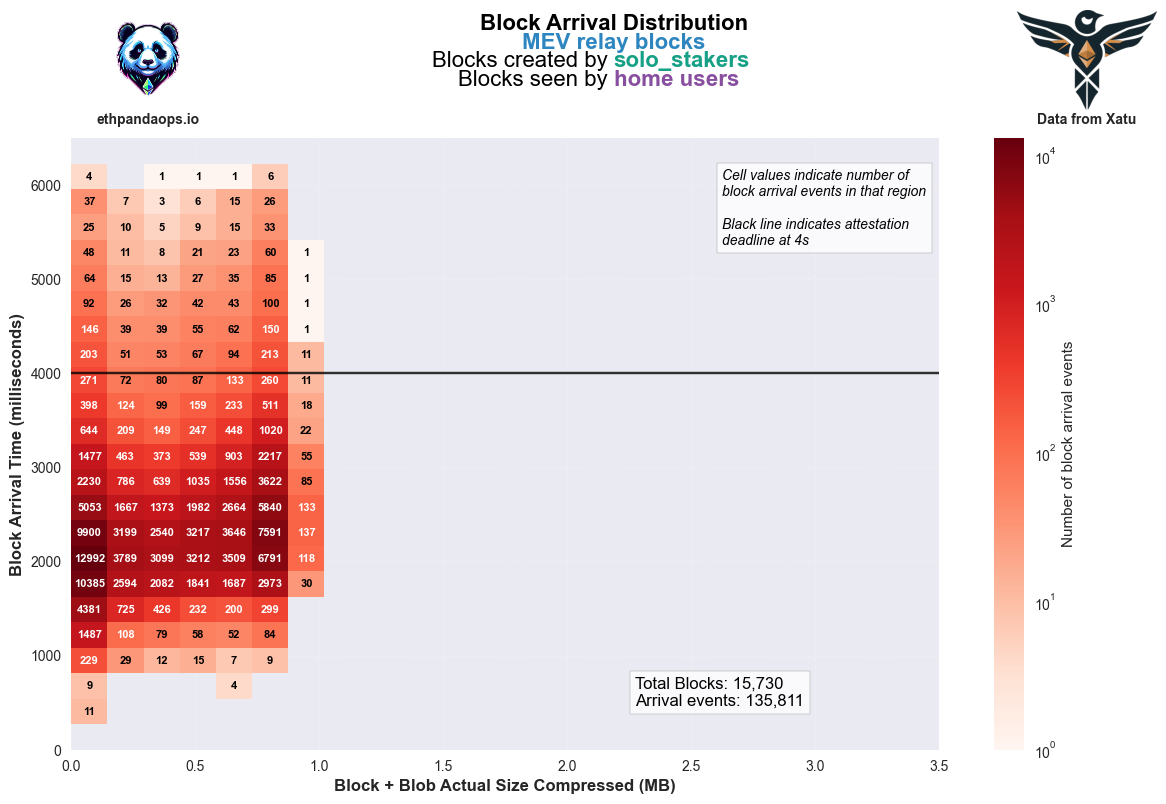

Creating plot for MEV: False Historical p99 block size with solo_stakers and observed by home users


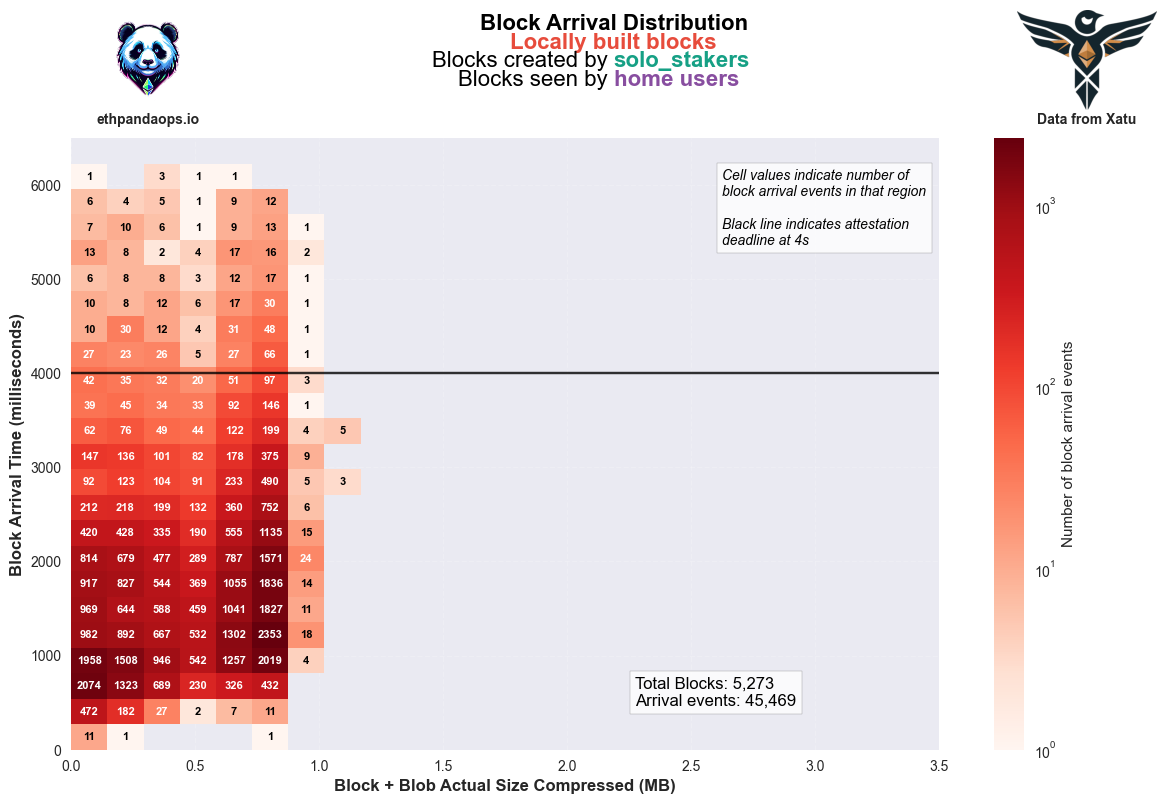

Creating plot for MEV: None Historical p99 block size with solo_stakers and observed by home users


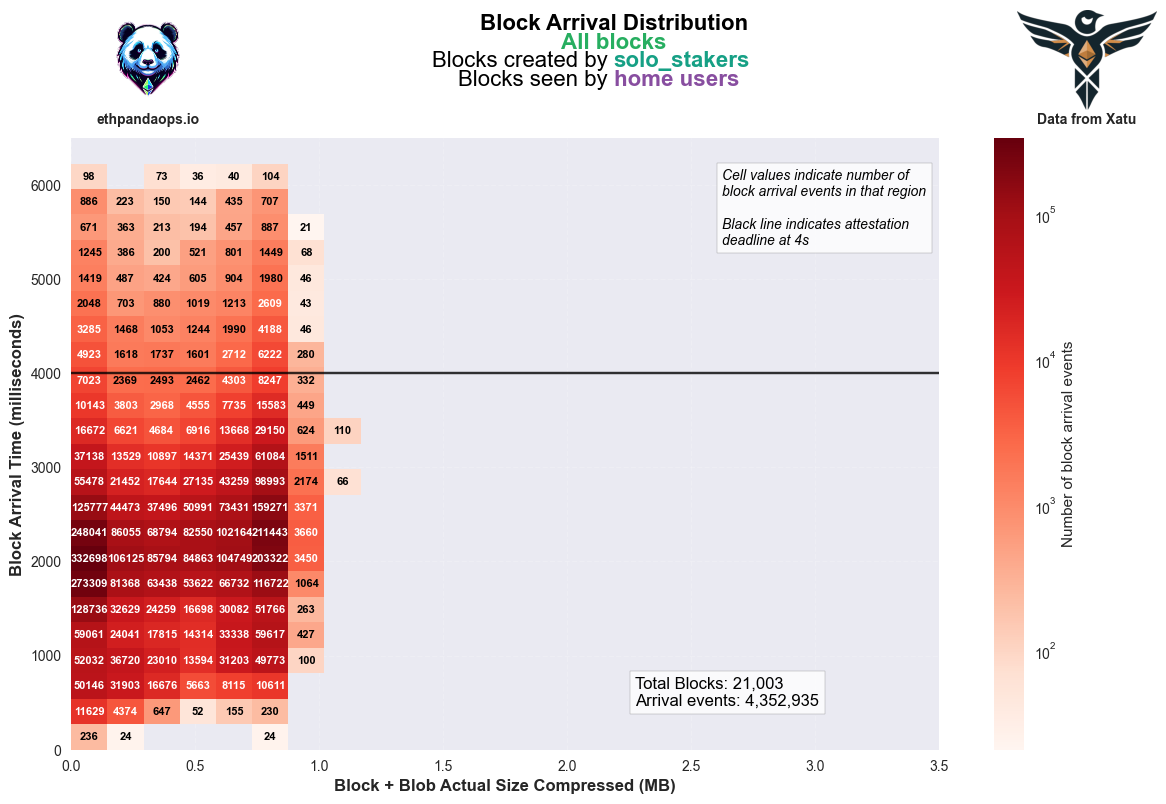

Creating plot for MEV: True Historical p99 block size with kiln and observed by home users


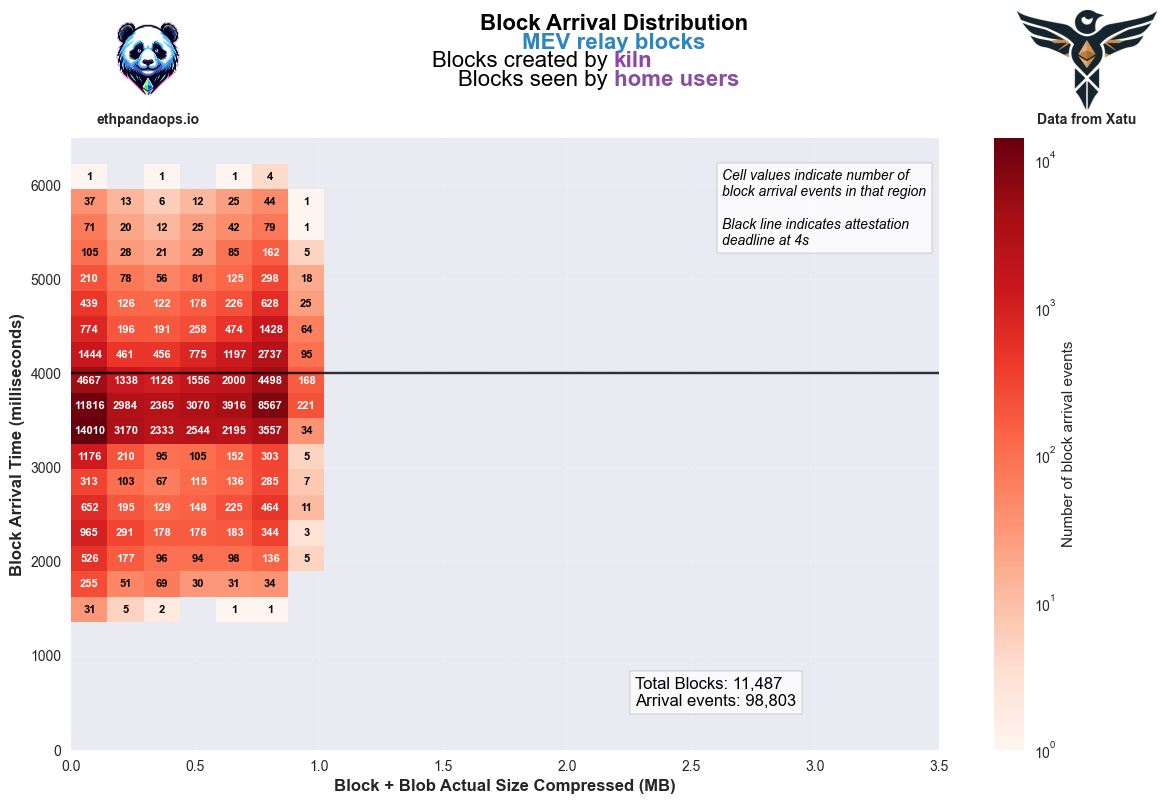

Creating plot for MEV: False Historical p99 block size with kiln and observed by home users
Skipping kiln observed by home users (MEV: False) due to low block count: 35
Creating plot for MEV: None Historical p99 block size with kiln and observed by home users


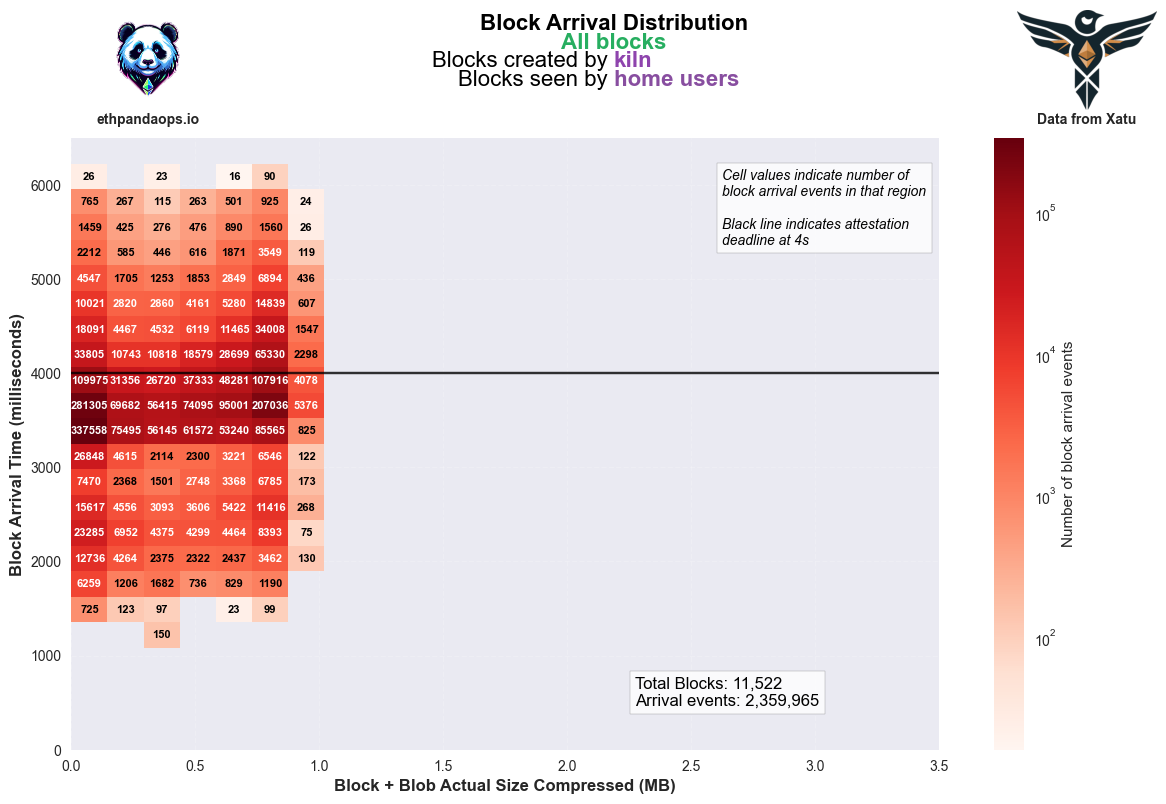

Creating plot for MEV: True Worst case with EIP7623 with solo_stakers and observed by home users


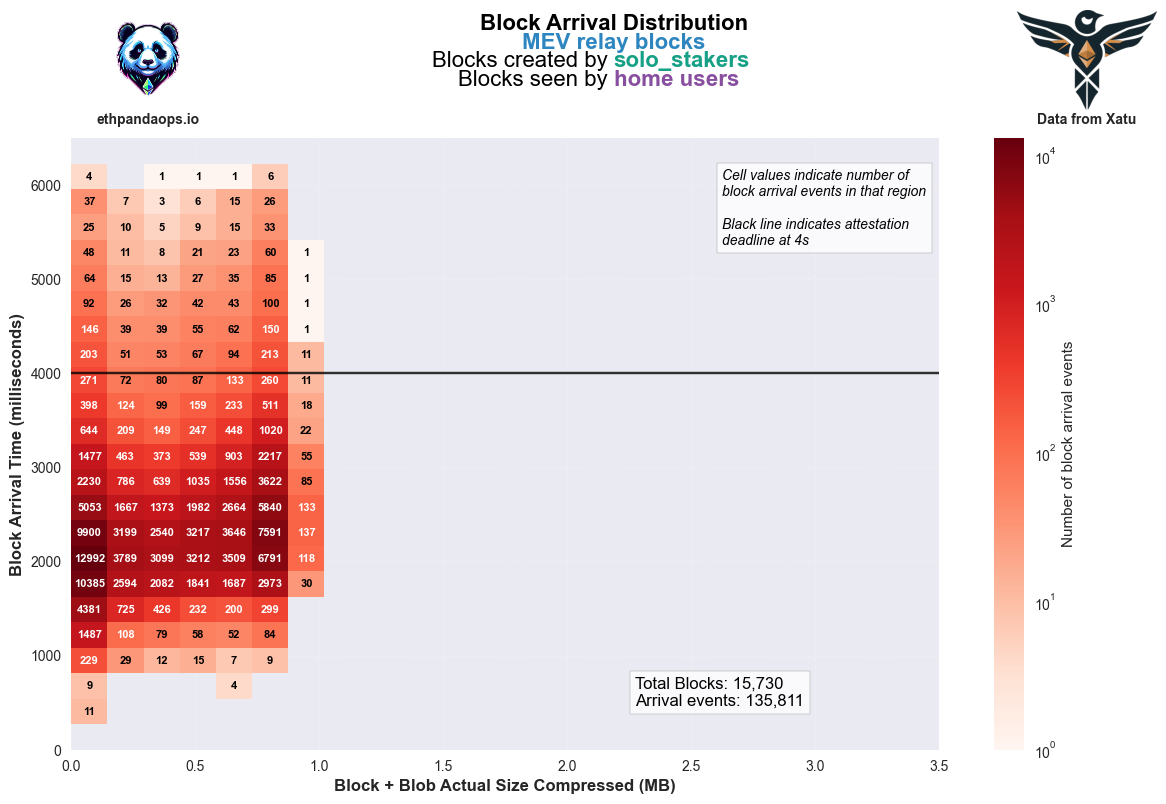

Creating plot for MEV: False Worst case with EIP7623 with solo_stakers and observed by home users


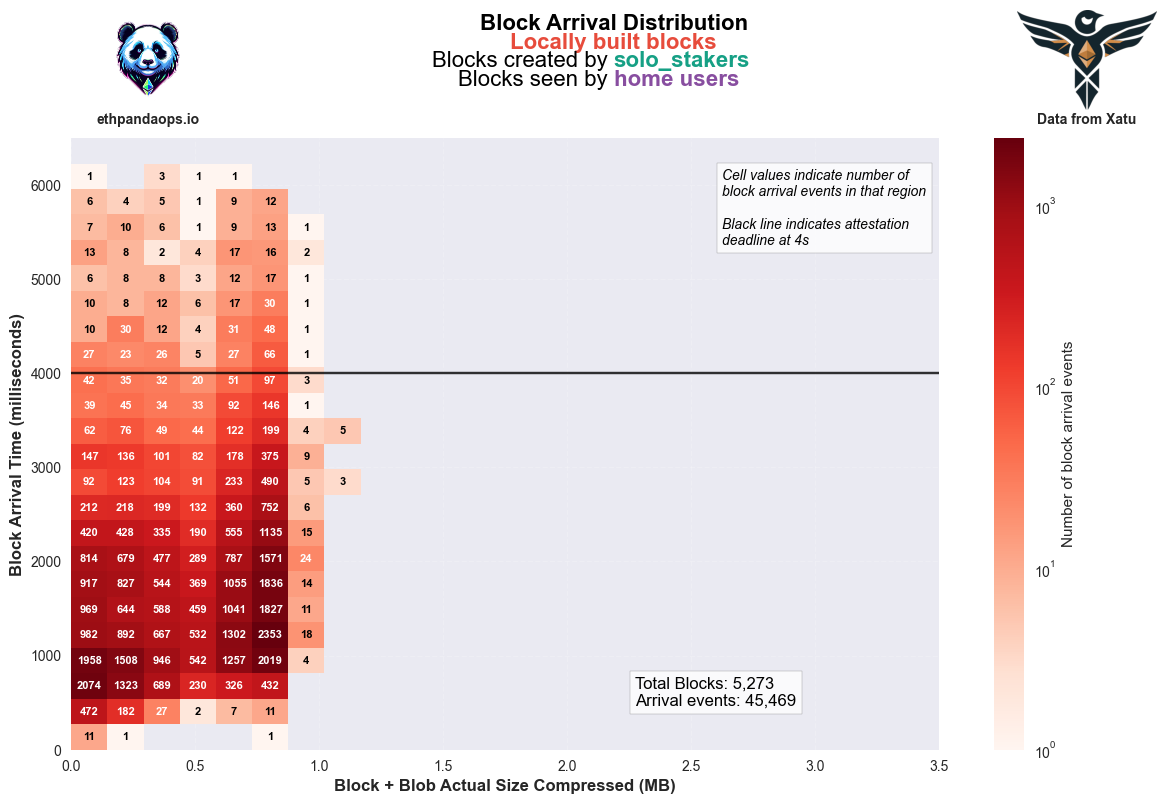

Creating plot for MEV: None Worst case with EIP7623 with solo_stakers and observed by home users


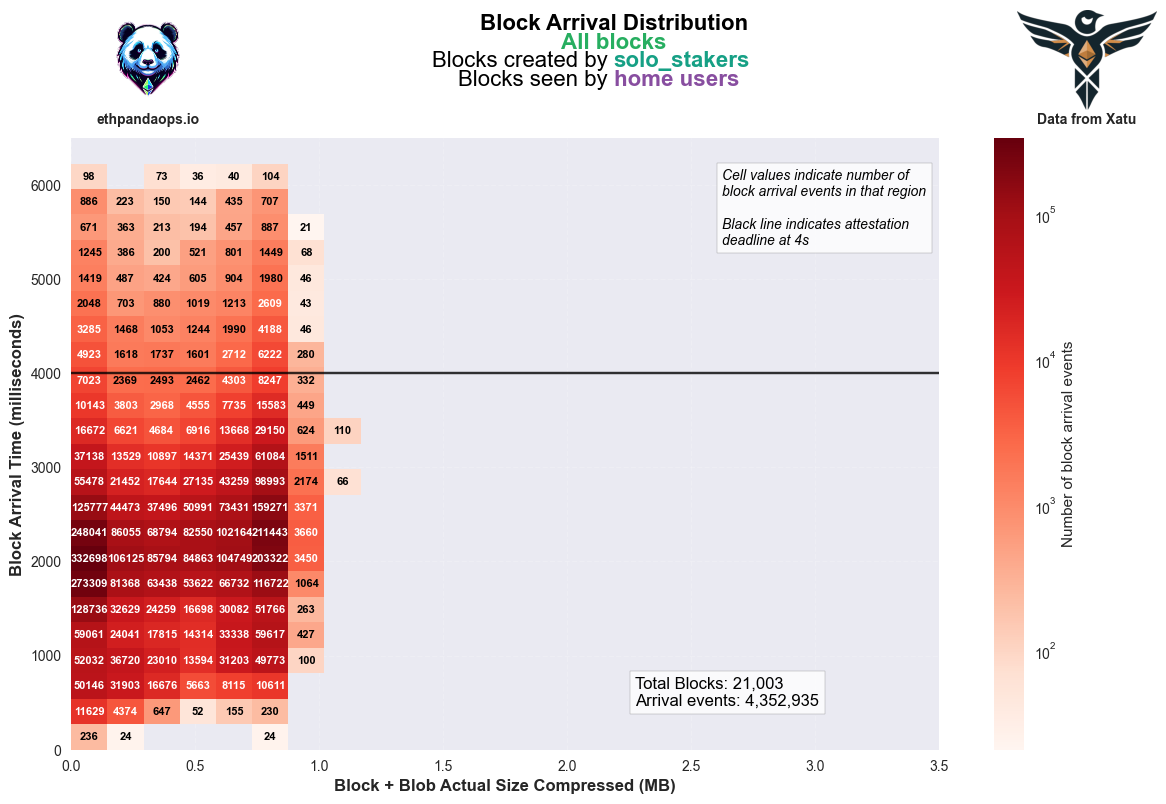

Creating plot for MEV: True Worst case with EIP7623 with kiln and observed by home users


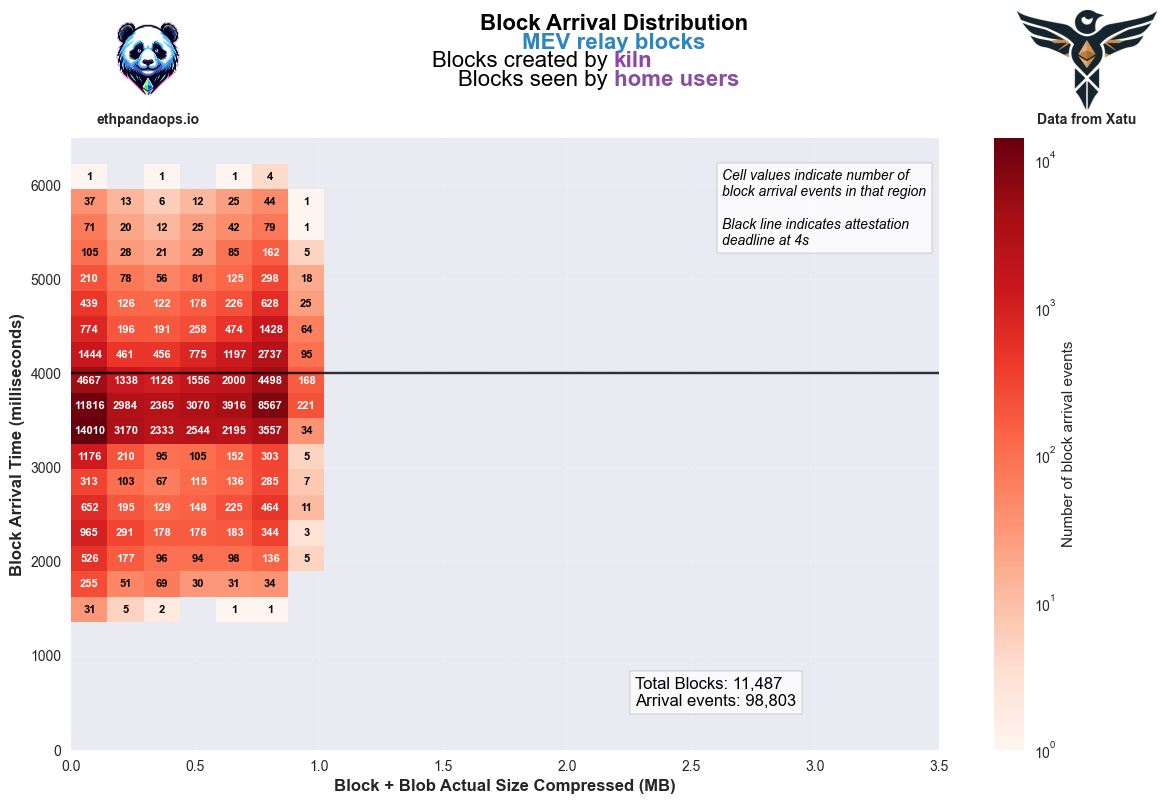

Creating plot for MEV: False Worst case with EIP7623 with kiln and observed by home users
Skipping kiln observed by home users (MEV: False) due to low block count: 35
Creating plot for MEV: None Worst case with EIP7623 with kiln and observed by home users


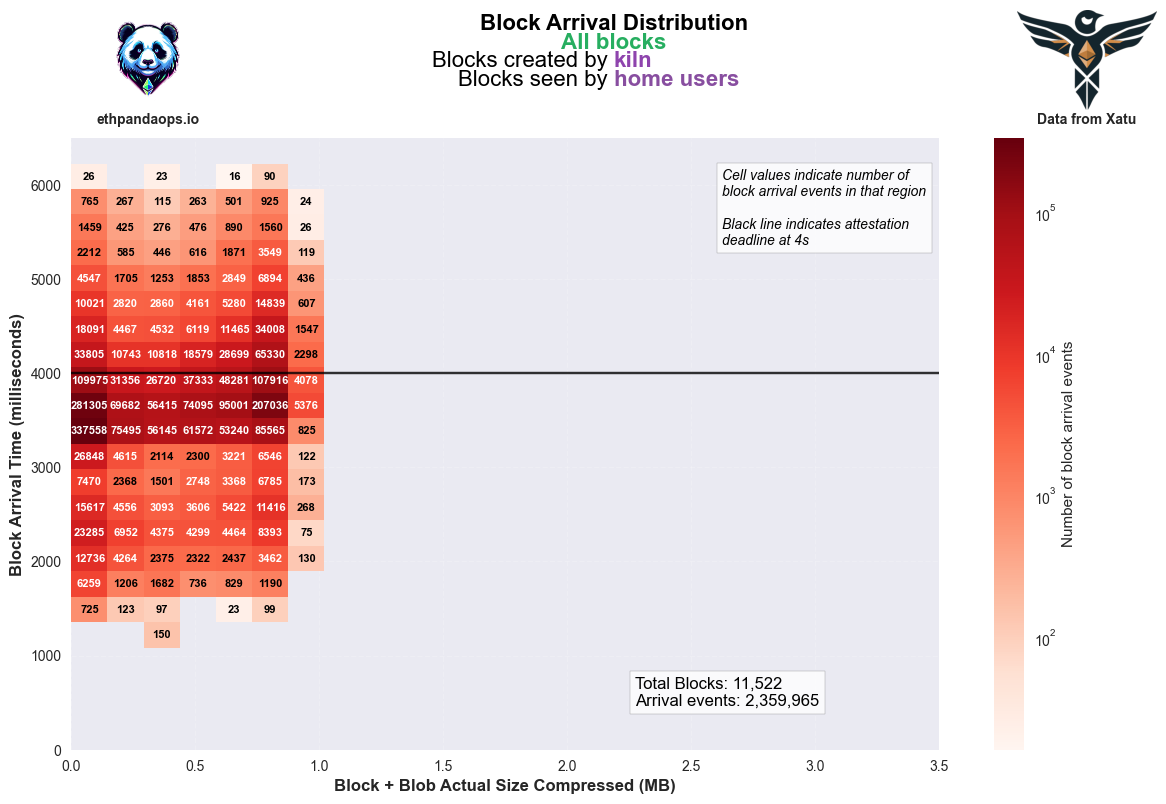

In [18]:
from matplotlib import gridspec, colors

# Define color map for title parameters
title_param_colors = {
    'mev_status': ['#2E86C1', '#E74C3C', '#27AE60'],  
    'entity_colors': ['#8E44AD', '#E67E22', '#16A085', '#2980B9', '#C0392B', '#7D3C98', '#F39C12', '#1ABC9C', '#2E86C1', '#E74C3C', '#27AE60', '#8E44AD', '#D35400', '#16A085', '#2980B9'],
    'observer_colors': ['#884EA0', '#D35400', '#1ABC9C']
}

observed_by_groups = ['home users', 'all nodes', 'ethpandaops']
figures = []
trend_data = []

# Load logos
ethpandaops_logo = plt.imread('./content/ethpandaops.png')
xatu_logo = plt.imread('./content/xatu.png')

feature_set = {'show_block_size': False, 'show_blob_count': False, 'show_trend_lines': False}

for block_size in block_sizes:
    for entity in entities:
        for is_mev in [True, False, None]:
            for observed_by_group in observed_by_groups:
                if observed_by_group == 'nan':
                    continue
                
                print(f"Creating plot for MEV: {is_mev} {block_size['label']} with {entity} and observed by {observed_by_group}")
                
                # Filter data based on conditions
                if is_mev is None:
                    slots_df = combined_data
                elif is_mev:
                    slots_df = mev_slots_with_sizes
                else:
                    slots_df = non_mev_slots_with_sizes
                    
                # Merge and filter data
                plot_data = (arrival_data
                    .merge(slots_df[['slot', 'block_total_bytes_compressed', 'total_blob_size', 'entity']], on='slot'))
                
                if observed_by_group != 'all nodes':
                    plot_data = plot_data.query(f"observed_by_group == '{observed_by_group}'")
                
                plot_data = plot_data.query(f"entity == '{entity}'")
                
                valid_mask = ~np.isnan(plot_data['arrival_time'])
                n_blocks = len(plot_data['slot'].unique())
                n_arrivals = np.sum(valid_mask)

                if n_blocks < 100:
                    print(f"Skipping {entity} observed by {observed_by_group} (MEV: {is_mev}) due to low block count: {n_blocks}")
                    continue

                if len(plot_data) == 0:
                    print(f"No data for {entity} observed by {observed_by_group}")
                    continue

                # Calculate total size in MB
                plot_data['total_size_mb'] = (plot_data['block_total_bytes_compressed'] + plot_data['total_blob_size']) / 1_000_000

                # Create figure and gridspec
                plt.style.use('seaborn-v0_8')
                fig = plt.figure(figsize=(14, 10))
                
                # Store metadata in figure for filename generation
                fig.metadata = {
                    'block_size': block_size['label'],
                    'entity': entity,
                    'is_mev': is_mev,
                    'observed_by': observed_by_group,
                    'features': '_'.join(k for k,v in feature_set.items() if v)
                }
                
                gs = gridspec.GridSpec(2, 1, height_ratios=[1, 10])
                
                # Create title axes
                title_ax = fig.add_subplot(gs[0])
                title_ax.axis('off')
                
                # Create main plot axes
                ax = fig.add_subplot(gs[1])

                # Calculate square bins based on axis limits
                x_max = 3.5  # MB
                y_max = 6500  # ms
                n_bins = 25  # Number of bins in each dimension
                
                x_bins = np.linspace(0, x_max, n_bins)
                y_bins = np.linspace(0, y_max, n_bins)
                
                heatmap, xedges, yedges = np.histogram2d(
                    plot_data['total_size_mb'],
                    plot_data['arrival_time'],
                    bins=[x_bins, y_bins]
                )
                
                # Plot heatmap with white to red colormap
                im = ax.pcolormesh(xedges, yedges, heatmap.T, 
                                 cmap='Reds', 
                                 norm=colors.LogNorm())
                cbar = fig.colorbar(im, ax=ax, label='Number of block arrival events')

                # Add count text to each cell
                for i in range(len(x_bins)-1):
                    for j in range(len(y_bins)-1):
                        if heatmap[i,j] > 0:  # Only show non-zero counts
                            ax.text(x_bins[i] + (x_bins[1]-x_bins[0])/2,
                                  y_bins[j] + (y_bins[1]-y_bins[0])/2,
                                  int(heatmap[i,j]),
                                  ha='center', va='center',
                                  color='white' if heatmap[i,j] > np.max(heatmap)/128 else 'black', # Changed from /4 to /8
                                  fontsize=8,
                                  fontweight='bold')

                # Add attestation deadline line
                ax.axhline(y=4000, color='black', linestyle='-', alpha=0.8)

                mev_text = "MEV relay blocks" if is_mev else "Locally built blocks" if is_mev is not None else "All blocks"
                
                # Add title text to title axes
                title = 'Block Arrival Distribution'
                title_ax.text(0.5, 0.6, title, ha='center', va='bottom',
                        fontsize=16, color='black', fontweight='bold')
                title_ax.text(0.5, 0.3, mev_text, ha='center', va='bottom',
                        fontsize=16, color=title_param_colors['mev_status'][0 if is_mev else 1 if is_mev is not None else 2], 
                        fontweight='bold')
                title_ax.text(0.5, 0.0, 'Blocks created by ', ha='right', va='bottom',
                        fontsize=16, color='black')
                title_ax.text(0.5, 0.0, entity, ha='left', va='bottom',
                        fontsize=16, color=title_param_colors['entity_colors'][hash(entity) % len(title_param_colors['entity_colors'])], 
                        fontweight='bold')
                title_ax.text(0.5, -0.3, 'Blocks seen by ', ha='right', va='bottom',
                        fontsize=16, color='black')
                title_ax.text(0.5, -0.3, observed_by_group, ha='left', va='bottom',
                        fontsize=16, color=title_param_colors['observer_colors'][hash(observed_by_group) % len(title_param_colors['observer_colors'])], 
                        fontweight='bold')

                # Add legend for cell values and attestation deadline
                legend_text = ('Cell values indicate number of\nblock arrival events in that region\n\n'
                             'Black line indicates attestation\ndeadline at 4s')
                ax.text(0.75, 0.95, legend_text,
                        ha='left', va='top', transform=ax.transAxes,
                        fontsize=10, color='black', style='italic',
                        bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

                # Add logos and text
                logo_ax1 = fig.add_axes([0.8, 0.75, 0.1, 0.1]) 
                logo_ax1.imshow(xatu_logo)
                logo_ax1.axis('off')
                
                text_ax = fig.add_axes([0.8, 0.73, 0.1, 0.02])
                text_ax.text(0.5, 0.5, 'Data from Xatu', ha='center', va='center', fontsize=10, fontweight='bold')
                text_ax.axis('off')

                logo_ax2 = fig.add_axes([0.13, 0.75, 0.1, 0.1])
                logo_ax2.imshow(ethpandaops_logo)
                logo_ax2.axis('off')

                text_ax = fig.add_axes([0.13, 0.73, 0.1, 0.02])
                text_ax.text(0.5, 0.5, 'ethpandaops.io', ha='center', va='center', fontsize=10, fontweight='bold')
                text_ax.axis('off')

                # Add block and arrival counts
                ax.text(0.65, 0.12, f'Total Blocks: {n_blocks:,}\nArrival events: {n_arrivals:,}', 
                        ha='left', va='top', transform=ax.transAxes,
                        fontsize=12, color='black', 
                        bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
                ax.set_xlabel('Block + Blob Actual Size Compressed (MB)', fontsize=12, fontweight='bold')
                ax.set_ylabel('Block Arrival Time (milliseconds)', fontsize=12, fontweight='bold')
                ax.grid(True, alpha=0.2, linestyle='--')
                ax.set_ylim(0, 6500)
                ax.set_xlim(0, 3.5)

                plt.subplots_adjust(top=0.85)
                plt.show()
                plt.close()

In [19]:
from matplotlib import gridspec

# Define color map for title parameters
title_param_colors = {
    'mev_status': ['#2E86C1', '#E74C3C', '#27AE60'],  
    'entity_colors': ['#8E44AD', '#E67E22', '#16A085', '#2980B9', '#C0392B', '#7D3C98', '#F39C12', '#1ABC9C', '#2E86C1', '#E74C3C', '#27AE60', '#8E44AD', '#D35400', '#16A085', '#2980B9'],
    'observer_colors': ['#884EA0', '#D35400', '#1ABC9C']
}

observed_by_groups = ['home users', 'all nodes', 'ethpandaops']
figures = []
trend_data = []

# Load logos
ethpandaops_logo = plt.imread('./content/ethpandaops.png')
xatu_logo = plt.imread('./content/xatu.png')

# Feature flags for gradual fade in
feature_sets = [
    {'show_block_size': False, 'show_blob_count': False, 'show_trend_lines': True},
    {'show_block_size': False, 'show_blob_count': False, 'show_trend_lines': False},
    {'show_block_size': True, 'show_blob_count': True, 'show_trend_lines': False}, 
    {'show_block_size': True, 'show_blob_count': True, 'show_trend_lines': True}
]

for feature_set in feature_sets:
    for block_size in block_sizes:
        for entity in entities:
            for is_mev in [True, False, None]:
                for observed_by_group in observed_by_groups:
                    if observed_by_group == 'nan':
                        continue
                    
                    print(f"Creating plot for MEV: {is_mev} {block_size['label']} with {entity} and observed by {observed_by_group}")
                    
                    # Filter data based on conditions
                    if is_mev is None:
                        slots_df = combined_data
                    elif is_mev:
                        slots_df = mev_slots_with_sizes
                    else:
                        slots_df = non_mev_slots_with_sizes
                        
                    # Merge and filter data
                    plot_data = (arrival_data
                        .merge(slots_df[['slot', 'block_total_bytes_compressed', 'total_blob_size', 'entity']], on='slot'))
                    
                    if observed_by_group != 'all nodes':
                        plot_data = plot_data.query(f"observed_by_group == '{observed_by_group}'")
                    
                    plot_data = plot_data.query(f"entity == '{entity}'")
                    
                    valid_mask = ~np.isnan(plot_data['arrival_time'])
                    n_blocks = len(plot_data['slot'].unique())
                    n_arrivals = np.sum(valid_mask)

                    if n_blocks < 100:
                        print(f"Skipping {entity} observed by {observed_by_group} (MEV: {is_mev}) due to low block count: {n_blocks}")
                        continue

                    if len(plot_data) == 0:
                        print(f"No data for {entity} observed by {observed_by_group}")
                        continue

                    # Calculate total size in MB
                    plot_data['total_size_mb'] = (plot_data['block_total_bytes_compressed'] + plot_data['total_blob_size']) / 1_000_000

                    # Create figure and gridspec
                    plt.style.use('seaborn-v0_8')
                    fig = plt.figure(figsize=(14, 10))
                    
                    # Store metadata in figure for filename generation
                    fig.metadata = {
                        'block_size': block_size['label'],
                        'entity': entity,
                        'is_mev': is_mev,
                        'observed_by': observed_by_group,
                        'features': '_'.join(k for k,v in feature_set.items() if v)
                    }
                    
                    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 10])
                    
                    # Create title axes
                    title_ax = fig.add_subplot(gs[0])
                    title_ax.axis('off')
                    
                    # Create main plot axes
                    ax = fig.add_subplot(gs[1])
                    
                    # Plot all points
                    ax.scatter(plot_data['total_size_mb'], plot_data['arrival_time'], 
                              alpha=0.05, s=20, color='#404040', label='Individual blocks')

                    # Add trend lines if enabled
                    if feature_set['show_trend_lines'] and np.sum(valid_mask) > 1:
                        # Convert to numpy arrays and filter out NaN values
                        x_data = plot_data['total_size_mb'][valid_mask].values
                        y_data = plot_data['arrival_time'][valid_mask].values

                        # Calculate p99, p95 and p50 values per bin
                        bins = np.linspace(min(x_data), max(x_data), 20)
                        p99_vals = []
                        p95_vals = []
                        p50_vals = []
                        bin_centers = []
                        
                        for i in range(len(bins)-1):
                            mask = (x_data >= bins[i]) & (x_data < bins[i+1])
                            if np.sum(mask) > 0:
                                p99_vals.append(np.percentile(y_data[mask], 99))
                                p95_vals.append(np.percentile(y_data[mask], 95))
                                p50_vals.append(np.percentile(y_data[mask], 50))
                                bin_centers.append((bins[i] + bins[i+1])/2)

                        # Fit trend lines to percentile data
                        if len(bin_centers) > 1:
                            p99_z = np.polyfit(bin_centers, p99_vals, 1)
                            p95_z = np.polyfit(bin_centers, p95_vals, 1)
                            p50_z = np.polyfit(bin_centers, p50_vals, 1)

                            metrics = [
                                ('p99', p99_z, '#cc4c02'),
                                ('p95', p95_z, '#de2d26'), 
                                ('p50', p50_z, '#2171b5')
                            ]
                            x_range = np.linspace(0, 3.5, 100)

                            for label, z, color in metrics:
                                if z[0] > 0:
                                    max_size = (4000 - z[1]) / z[0]
                                    p_fit = np.poly1d(z)
                                    
                                    ax.plot(x_range, p_fit(x_range), '--', color=color, alpha=0.8, linewidth=2, label=f'{label} trend')
                                    
                                    if feature_set['show_blob_count']:
                                        if label == 'p95':
                                            offset = 3500
                                        else:
                                            offset = 4250
                                        ax.annotate(
                                            f'{label} block arrival trend\n crosses 4s at {max_size:.2f} MB',
                                            xy=(max_size, 4000),
                                            xytext=(max_size-0.5, offset),
                                            arrowprops=dict(facecolor=color, shrink=0.05, width=2, headwidth=8),
                                            color=color,
                                            fontsize=10,
                                            bbox=dict(facecolor='white', edgecolor=color, alpha=0.9, boxstyle='round,pad=0.5')
                                        )

                                    base_size = block_size['value']
                                    max_blobs = int((max_size - base_size) / 0.128)
                                    trend_data.append({
                                        'entity': entity,
                                        'is_mev': is_mev,
                                        'observed_by': observed_by_group,
                                        'metric': label,
                                        'max_size_mb': max_size,
                                        'max_blobs': max_blobs,
                                        'slope': z[0],
                                        'intercept': z[1]
                                    })

                    # Rest of plot formatting
                    ax.axhline(y=4000, color='black', linestyle='-', alpha=0.8, linewidth=2, label='Attestation deadline (4s)')
                    
                    if feature_set['show_block_size']:
                        base_size = block_size['value']
                        ax.axvspan(0, base_size, color='#90EE90', alpha=0.3, zorder=0)
                        ax.axvline(x=base_size, color='#228B22', linestyle='--', alpha=0.7, linewidth=2, 
                                  label=f"{block_size['label']}")

                    if feature_set['show_blob_count']:
                        blob_increment = 0.128
                        for i in range(1, int((3.5 - base_size) / blob_increment) + 1):
                            x_pos = base_size + (i * blob_increment)
                            ax.axvspan(base_size + ((i-1) * blob_increment), x_pos, color='#ADD8E6', alpha=0.2, zorder=0)
                            ax.axvline(x=x_pos, color='#4169E1', linestyle=':', alpha=0.4, linewidth=1.5)
                            ax.text(x_pos - blob_increment/2, 1100,
                                    str(i),
                                    color='#4169E1',
                                    alpha=1,
                                    fontsize=10,
                                    bbox=dict(facecolor='white', alpha=0.9),
                                    ha='center')
                        ax.plot([], [], color='#4169E1', alpha=0.4, label='Maximum number of blobs')

                    ax.legend(loc='upper right', frameon=True, framealpha=1.0, fontsize=10,
                             bbox_to_anchor=(0.99, 0.99), borderaxespad=0, facecolor='white')

                    mev_text = "MEV relay blocks" if is_mev else "Locally built blocks" if is_mev is not None else "All blocks"
                    
                    # Add title text to title axes
                    title = 'Predicted Maximum Blob Count' if feature_set['show_blob_count'] else 'Block Arrival Trend'
                    title_ax.text(0.5, 0.6, title, ha='center', va='bottom',
                            fontsize=16, color='black', fontweight='bold')
                    title_ax.text(0.5, 0.3, mev_text, ha='center', va='bottom',
                            fontsize=16, color=title_param_colors['mev_status'][0 if is_mev else 1 if is_mev is not None else 2], 
                            fontweight='bold')
                    title_ax.text(0.5, 0.0, 'Blocks created by ', ha='right', va='bottom',
                            fontsize=16, color='black')
                    title_ax.text(0.5, 0.0, entity, ha='left', va='bottom',
                            fontsize=16, color=title_param_colors['entity_colors'][hash(entity) % len(title_param_colors['entity_colors'])], 
                            fontweight='bold')
                    title_ax.text(0.5, -0.3, 'Blocks seen by ', ha='right', va='bottom',
                            fontsize=16, color='black')
                    title_ax.text(0.5, -0.3, observed_by_group, ha='left', va='bottom',
                            fontsize=16, color=title_param_colors['observer_colors'][hash(observed_by_group) % len(title_param_colors['observer_colors'])], 
                            fontweight='bold')

                    # Add logo in top right corner
                    logo_ax1 = fig.add_axes([0.8, 0.75, 0.1, 0.1]) 
                    logo_ax1.imshow(xatu_logo)
                    logo_ax1.axis('off')
                    
                    # Add "Data from Xatu" text below logo
                    text_ax = fig.add_axes([0.8, 0.73, 0.1, 0.02])
                    text_ax.text(0.5, 0.5, 'Data from Xatu', ha='center', va='center', fontsize=10, fontweight='bold')
                    text_ax.axis('off')

                    # Add ethpandaops logo in top left corner
                    logo_ax2 = fig.add_axes([0.13, 0.75, 0.1, 0.1])
                    logo_ax2.imshow(ethpandaops_logo)
                    logo_ax2.axis('off')

                    # Add "Data from ethpandaops" text below logo
                    text_ax = fig.add_axes([0.13, 0.73, 0.1, 0.02])
                    text_ax.text(0.5, 0.5, 'ethpandaops.io', ha='center', va='center', fontsize=10, fontweight='bold')
                    text_ax.axis('off')

                    # Add block and arrival counts
                    ax.text(0.65, 0.12, f'Total Blocks: {n_blocks:,}\nArrival events: {n_arrivals:,}', 
                            ha='left', va='top', transform=ax.transAxes,
                            fontsize=12, color='black', 
                            bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
                    ax.set_xlabel('Block + Blob Actual Size Compressed (MB)', fontsize=12, fontweight='bold')
                    ax.set_ylabel('Block Arrival Time (milliseconds)', fontsize=12, fontweight='bold')
                    ax.grid(True, alpha=0.2, linestyle='--')
                    ax.set_ylim(0000, 6500)
                    ax.set_xlim(0, 3.5)

                    plt.subplots_adjust(top=0.85)

                    if len(trend_data) > 0:
                        p99_data = [d for d in trend_data if d['metric'] == 'p99']
                        if p99_data:
                            figures.append((p99_data[-1]['max_size_mb'], fig))
                    # plt.show()
                    plt.close()

figures.sort(key=lambda x: x[0], reverse=True)
trend_df = pd.DataFrame(trend_data)
# print(trend_df)


Creating plot for MEV: True Historical p99 block size with solo_stakers and observed by home users
Creating plot for MEV: False Historical p99 block size with solo_stakers and observed by home users
Creating plot for MEV: None Historical p99 block size with solo_stakers and observed by home users
Creating plot for MEV: True Historical p99 block size with kiln and observed by home users
Creating plot for MEV: False Historical p99 block size with kiln and observed by home users
Skipping kiln observed by home users (MEV: False) due to low block count: 35
Creating plot for MEV: None Historical p99 block size with kiln and observed by home users
Creating plot for MEV: True Worst case with EIP7623 with solo_stakers and observed by home users
Creating plot for MEV: False Worst case with EIP7623 with solo_stakers and observed by home users
Creating plot for MEV: None Worst case with EIP7623 with solo_stakers and observed by home users
Creating plot for MEV: True Worst case with EIP7623 with ki

In [20]:
# Clear and create output directory
import os
import shutil

output_dir = './blob-predictions'
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir)

# Save each figure as PNG
for i, (size_mb, fig) in enumerate(figures):
    metadata = fig.metadata
    # Create subdirectory if it doesn't exist
    subdir = os.path.join(output_dir, metadata["features"])
    os.makedirs(subdir, exist_ok=True)
    
    # Clean filename by replacing spaces with underscores
    clean_filename = f'block_arrival_trend_{metadata["entity"]}_{metadata["block_size"]}_{metadata["is_mev"]}_{metadata["observed_by"]}'.replace(' ', '_')
    filename = os.path.join(subdir, f'{clean_filename}.png')
    
    fig.savefig(filename, bbox_inches='tight', dpi=300)
